<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Hotel_LSTM_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline


In [2]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving hotel_data_clean.csv to hotel_data_clean.csv


In [3]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['hotel_data_clean.csv']))

In [4]:
data.head()

,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
0,0,0,La Quinta,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,hotel dump upon checking told place booked fol...,1.0,"['hotel', 'dump', 'upon', 'checking', 'told', ...",Negative,15400
1,1,1,The Point,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,stayed point five days back june 2011 wife ele...,5.0,"['stayed', 'point', 'five', 'days', 'back', 'j...",Positive,3702
2,2,1,The Point,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,point exceeds perfection moment arrive prepare...,5.0,"['point', 'exceeds', 'perfection', 'moment', '...",Positive,3738
3,3,1,The Point,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,review long overdue tell many people place fel...,5.0,"['review', 'long', 'overdue', 'tell', 'many', ...",Positive,4593
4,4,1,The Point,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,picked airport car vacuum cleaned long time mi...,2.0,"['picked', 'airport', 'car', 'vacuum', 'cleane...",Negative,4657


In [5]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [6]:
data.head()


,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
0,0,0,La Quinta,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,hotel dump upon checking told place booked fol...,1.0,"['hotel', 'dump', 'upon', 'checking', 'told', ...",0,15400
1,1,1,The Point,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,stayed point five days back june 2011 wife ele...,5.0,"['stayed', 'point', 'five', 'days', 'back', 'j...",1,3702
2,2,1,The Point,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,point exceeds perfection moment arrive prepare...,5.0,"['point', 'exceeds', 'perfection', 'moment', '...",1,3738
3,3,1,The Point,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,review long overdue tell many people place fel...,5.0,"['review', 'long', 'overdue', 'tell', 'many', ...",1,4593
4,4,1,The Point,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,picked airport car vacuum cleaned long time mi...,2.0,"['picked', 'airport', 'car', 'vacuum', 'cleane...",0,4657


In [7]:
# Checking for missing values
pd.isnull(data).any()

Index         False
Hotel_id      False
Hotel         False
Title          True
Users         False
Reviews        True
Text_Clean     True
Rating         True
tokens        False
Sentiment     False
User_id       False
dtype: bool

In [9]:
#Filing the missing Review with 'na'
data['Reviews'] = data['Reviews'].fillna('').apply(str)
data['Title'] = data['Title'].fillna('').apply(str)
data['Text_Clean'] = data['Text_Clean'].fillna('').apply(str)

In [10]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (24151, 11)
Index(['Index', 'Hotel_id', 'Hotel', 'Title', 'Users', 'Reviews', 'Text_Clean',
       'Rating', 'tokens', 'Sentiment', 'User_id'],
      dtype='object')
No. of unique classes 2


In [11]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [12]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [13]:
macronum=sorted(set(data['Sentiment']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Sentiment']=data['Sentiment'].apply(fun)

In [14]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Sentiment']:
    labels.append(idx)

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 45777


In [16]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (24151, 1000)
Shape of Label Tensor: (24151, 2)


In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-09-05 06:18:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-05 06:18:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-05 06:18:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [18]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	    sample_data
glove.6B.200d.txt  glove.6B.50d.txt   hotel_data_clean.csv
/content


In [20]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [21]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         4577800   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 4,739,002
Trainable params: 4,739,002
Non-trainable params: 0
_________________________________________________________________


In [24]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])

Epoch 1/7
604/604 [==============================] - ETA: 0s - loss: 0.3928 - acc: 0.8302
Epoch 00001: val_acc improved from -inf to 0.85694, saving model to model_rnn.hdf5
604/604 [==============================] - 846s 1s/step - loss: 0.3928 - acc: 0.8302 - val_loss: 0.3364 - val_acc: 0.8569
Epoch 2/7
604/604 [==============================] - ETA: 0s - loss: 0.3114 - acc: 0.8726
Epoch 00002: val_acc improved from 0.85694 to 0.86915, saving model to model_rnn.hdf5
604/604 [==============================] - 846s 1s/step - loss: 0.3114 - acc: 0.8726 - val_loss: 0.3168 - val_acc: 0.8692
Epoch 3/7
604/604 [==============================] - ETA: 0s - loss: 0.2734 - acc: 0.8894
Epoch 00003: val_acc improved from 0.86915 to 0.87143, saving model to model_rnn.hdf5
604/604 [==============================] - 845s 1s/step - loss: 0.2734 - acc: 0.8894 - val_loss: 0.3192 - val_acc: 0.8714
Epoch 4/7
604/604 [==============================] - ETA: 0s - loss: 0.2452 - acc: 0.8992
Epoch 00004: val_ac

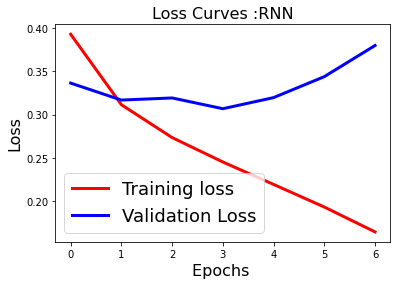

In [25]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

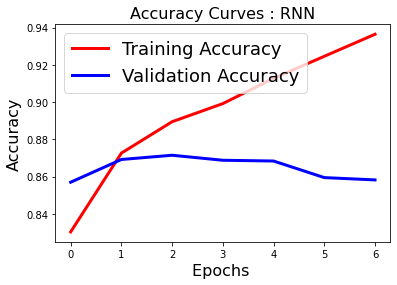

In [26]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

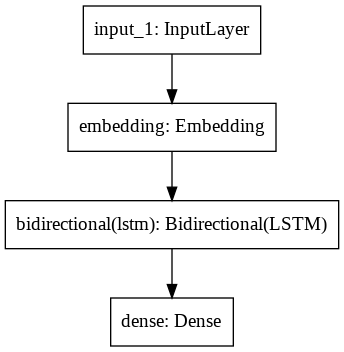

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='rnn_model.png')